- This analysis is adapted from [Statistical Arbitrage in the U.S. Equities Market
](https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf) by Marco Avellaneda and Jeong-Hyun Lee

- It's well known that the main driving "force" or factor behind most of the moves you see in stocks are driven by the "market" at large. Meaning if the market goes up, it's likely that any stock of interest is also going to go up over the same time period.
- Once you start getting into more niche industries, things like oil prices and other commodity prices, interest rates etc can have a bigger impact on certain stocks but usually to a lesser degree than the market.
- It's also known that in "normal" times, even though the market may be the largest factor for explaining returns of any individual stock, there's still a decent amount of variation left unexplained.
- Interestingly in times of crises, this amount of variation that the market explains goes up drastically.
- I want to investigate how much on average returns can be explained by the market in normal times vs times of crisis like Covid 19.

- Start by importing my dataset of stock prices for a large chunk of the stocks traded in the US.

In [2]:
# installs common libraries for colab
!pip install git+https://github.com/RWLab/rwPtools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

  Cloning https://github.com/RWLab/rwPtools to /tmp/pip-req-build-g2jkpa2n
  Running command git clone --filter=blob:none --quiet https://github.com/RWLab/rwPtools /tmp/pip-req-build-g2jkpa2n
  Resolved https://github.com/RWLab/rwPtools to commit 9d0bbdafc8ee15270f9d84fd1c038ee2779f74f4
  Preparing metadata (setup.py) ... done
  Created wheel for rwptools: filename=rwptools-0.1-py3-none-any.whl size=3457 sha256=04b0e190ed139843558473017e85a67cba3eea2b8ff679b9e35a36f7588d71f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5gvsq20/wheels/0c/6b/09/975b604a42c11d44d66f40d3d6a953691711dee640d199b68b
Successfully built rwptools


In [1]:
import requests

# specify the S3 bucket and file path
s3_bucket = "https://sharadar.o7y6.c18.e2-1.dev"
s3_file_path = "SEP-old.zip"

# download the file
s3_file_url = "https://sharadar.o7y6.c18.e2-1.dev/SEP-old.zip"
response = requests.get(s3_file_url)
f = open("SEP-old.zip", "wb")

f.write(response.content)

f.close()

In [3]:
data = pd.read_csv("SEP-old.zip")
data.head()

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated
0,ABILF,2021-11-09,0.30,0.33,0.30,0.33,7500.0,0.33,0.33,2021-11-09
1,ABILF,2021-11-08,0.35,0.35,0.35,0.35,0.0,0.35,0.35,2021-11-09
2,AAC,2021-09-24,9.74,9.75,9.73,9.75,38502.0,9.75,9.75,2021-09-24
3,AAC.U,2021-09-24,9.95,9.95,9.90,9.90,2692.0,9.90,9.90,2021-09-24
4,AAC.WS,2021-09-24,0.92,0.92,0.87,0.89,38784.0,0.89,0.89,2021-09-24


In [4]:
data.shape

(16589379, 10)

In [5]:
data.ticker.nunique()

13471

In [8]:
data.date.min(), data.date.max()

('2012-01-03', '2022-07-11')

- Let's extract the date, ticker and close price columns

In [6]:
df = data[['date', "ticker", "closeadj"]]
df.head(2)

,date,ticker,closeadj
0,2021-11-09,ABILF,0.33
1,2021-11-08,ABILF,0.35


In [9]:
# now let's pivot it so that the date is the index
# ticker will be the columns and closeadj will be the values

pivot_df = df.pivot_table(index='date', columns='ticker', values='closeadj')
pivot_df.head()

ticker,A,AA,AAAP,AAC,AAC.U,AAC.WS,AACC,AACG,AACH,AACI,...,ZWRKU,ZWRKW,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYTO,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.994,NaN,NaN,NaN,NaN,NaN,4.11,2.376,NaN,NaN,...,NaN,NaN,NaN,3.061,NaN,NaN,NaN,0.023,0.430,1.74
2012-01-04,23.803,NaN,NaN,NaN,NaN,NaN,4.08,2.376,NaN,NaN,...,NaN,NaN,NaN,3.022,NaN,NaN,NaN,0.023,0.437,1.68
2012-01-05,24.336,NaN,NaN,NaN,NaN,NaN,4.10,2.367,NaN,NaN,...,NaN,NaN,NaN,3.120,NaN,NaN,NaN,0.023,0.449,1.81
2012-01-06,24.599,NaN,NaN,NaN,NaN,NaN,4.08,2.363,NaN,NaN,...,NaN,NaN,NaN,3.010,NaN,NaN,NaN,0.030,0.455,1.82
2012-01-09,25.244,NaN,NaN,NaN,NaN,NaN,4.15,2.396,NaN,NaN,...,NaN,NaN,NaN,3.057,NaN,NaN,NaN,0.030,0.424,1.84


In [10]:
pivot_df.shape

(2647, 13471)

In [11]:
# calculate percent returns
returns_df = pivot_df.pct_change()
returns_df.head(3)

ticker,A,AA,AAAP,AAC,AAC.U,AAC.WS,AACC,AACG,AACH,AACI,...,ZWRKU,ZWRKW,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYTO,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,-0.007960,NaN,NaN,NaN,NaN,NaN,-0.007299,0.000000,NaN,NaN,...,NaN,NaN,NaN,-0.012741,NaN,NaN,NaN,0.0,0.016279,-0.034483
2012-01-05,0.022392,NaN,NaN,NaN,NaN,NaN,0.004902,-0.003788,NaN,NaN,...,NaN,NaN,NaN,0.032429,NaN,NaN,NaN,0.0,0.027460,0.077381


- Now load in the PCA model from Sklearn

In [12]:
from sklearn.decomposition import PCA

- Create a loop with a 252 day lookback window
- Fit a PCA model and extract the percentage of variation explained by the top 15 largest eigenvectors and also measure how many components are needed to explain 55% of the variance.
- Save those values in a list so we can analyze later.

In [44]:
# Initialize a list to store the result dictionaries
results_list = []

# Loop through the DataFrame with a window of 252, starting from the first available window
for start in range(len(returns_df) - 251):
    window = returns_df.iloc[start:start + 252]

    # Drop rows that have all NA values
    window = window.dropna(axis=0, how='all')

    # Drop columns that have any NA values
    window = window.dropna(axis=1, how='any')

    # Apply PCA
    pca = PCA()
    pca.fit(window)

    # Calculate the variance explained by the top 15 components
    top_15_variance = pca.explained_variance_ratio_[:15].sum()

    # Calculate the cumulative explained variance
    cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

    # Find the number of components needed to explain at least 55% of the variance
    num_components_needed = (cumulative_explained_variance >= 0.55).tolist().index(True) + 1

    # Append the results as dictionaries to the results_list
    results_list.append({
        'date': window.index[-1],
        'top_15_variance': top_15_variance,
        'components_for_55': num_components_needed
    })

# Convert the results_list into a DataFrame
results_df = pd.DataFrame(results_list)

# Set the date as the index of the results DataFrame
results_df['date'] = pd.to_datetime(results_df['date'])
results_df.set_index('date', inplace=True)

In [45]:
results_df.head()

,top_15_variance,components_for_55
date,,
2013-01-03,0.641012,9
2013-01-04,0.637623,9
2013-01-07,0.637803,9
2013-01-08,0.637678,9
2013-01-09,0.640184,9


In [49]:
results_df.describe()

,top_15_variance,components_for_55
count,2396.000000,2396.000000
mean,0.804522,6.957012
std,0.205231,9.514664
min,0.409483,1.000000
25%,0.570566,1.000000
50%,0.844640,2.000000
75%,0.995161,14.000000
max,0.998418,31.000000


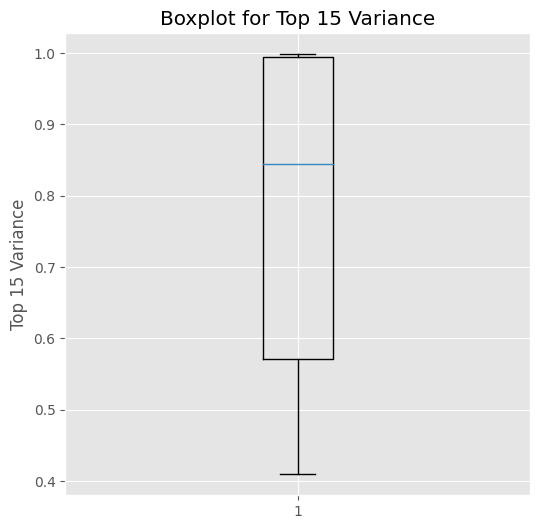

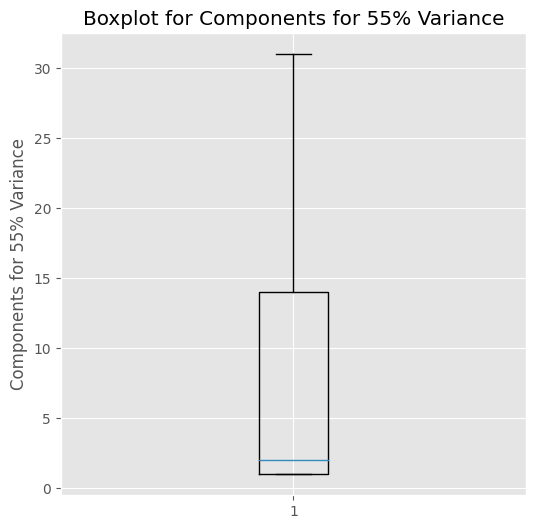

In [51]:
import matplotlib.pyplot as plt

# Create a boxplot for the top_15_variance column
plt.figure(figsize=(6, 6))
plt.boxplot(results_df['top_15_variance'])
plt.title('Boxplot for Top 15 Variance')
plt.ylabel('Top 15 Variance')
plt.show()

# Create a boxplot for the components_for_55 column
plt.figure(figsize=(6, 6))
plt.boxplot(results_df['components_for_55'])
plt.title('Boxplot for Components for 55% Variance')
plt.ylabel('Components for 55% Variance')
plt.show()


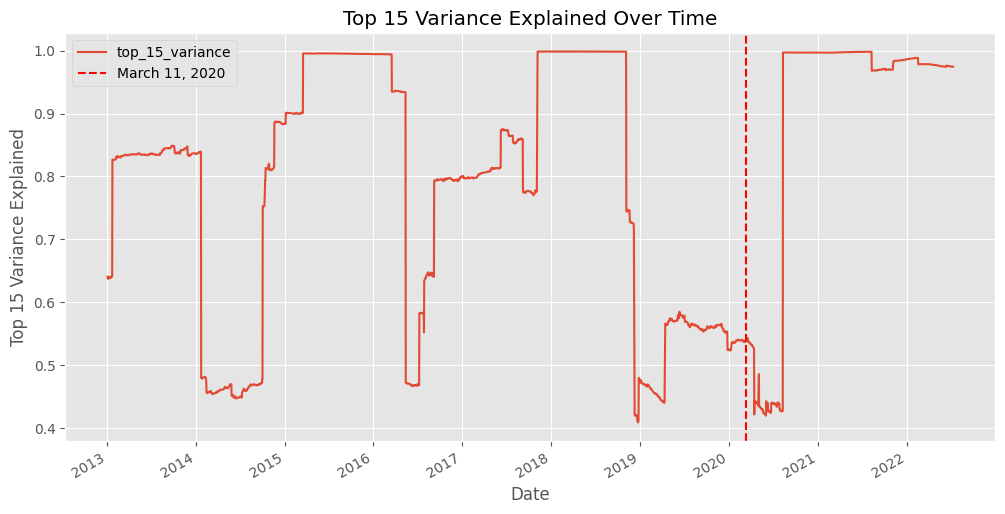

In [46]:
# Plot the top_15_variance column
ax = results_df['top_15_variance'].plot(figsize=(12, 6), title='Top 15 Variance Explained Over Time')
plt.xlabel('Date')
plt.ylabel('Top 15 Variance Explained')

# Add a vertical line at the date March 11, 2020
plt.axvline(x='2020-03-11', color='red', linestyle='--', label='March 11, 2020')
plt.legend()

plt.show()


- So it's obvious that the amount of variation explained by the top 15 eigenvectors changes drastically.
- But during times of turmoil pairwise correlations among stocks go up and so the number of factors needed to explain the variation decreases significantly.
- Keep in mind there's a 252 day rolling window used to fit the PCA model so the variance explained in that graph above should be "lagging".
- Particularly notice how the value was very low leading up to March 2020 and then it spiked up right after.

- Import the Vix Index and plot alongside the number of components needed to explain 55% of the variance in the stock universe.
- The Vix Index is a measure of implied volatility calculated from options on the SPX index. When the value is high, the market is pricing in a lot of volatility or uncertainty in stock returns over the next 30 days.

In [52]:
import yfinance as yf

# Define the VIX ticker symbol
vix_ticker = '^VIX'

# Fetch the VIX data
vix_data = yf.Ticker(vix_ticker).history(period='1d', start=results_df.index.min().date(), end=results_df.index.max().date())

# Remove timezone information from the vix_data index
vix_data.index = vix_data.index.tz_localize(None)

# Extract the Close values and align them with the results_df by index (date)
results_df['vix_close'] = vix_data['Close']

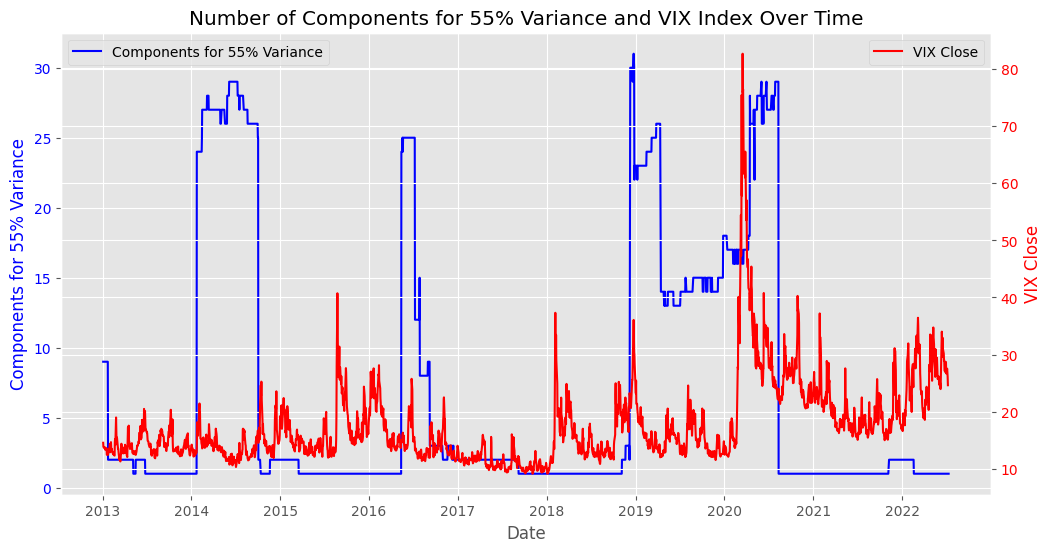

In [62]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the 'components_for_55' on the left y-axis
ax1.plot(results_df.index, results_df['components_for_55'], color='blue', label='Components for 55% Variance')
ax1.set_xlabel('Date')
ax1.set_ylabel('Components for 55% Variance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'vix_close' on the right y-axis
ax2.plot(results_df.index, results_df['vix_close'], color='red', label='VIX Close')
ax2.set_ylabel('VIX Close', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Number of Components for 55% Variance and VIX Index Over Time')
plt.show()


- So note when the components needed for 55% variance is low, that should correspond to volatile times, i.e. (relatively) high VIX values.

- It's a little harder to notice on this graph but basically anytime you see a relatively large spike in the VIX, you see the blue line drop precipitously thereafter.
- Again clearly obvious after March 2020.